# Network Inference Tutorial

In this tutorial, we will go through how to use the modelling and inference framework set up in this package. 

The first thing we will need to do is importnt the relevant packages: 

In [1]:
import netwin as nw 
from netwin.models import NetworkFKPP
from netwin import Model, VBModel, infer

import numpy as np 
import matplotlib.pyplot as plt

## Forward Model

The first step is to define a model using the Model abstract base class. This allows the model to interface appropriately with the inference classes. We can do this in the following way: 

In [2]:
class MyNetworkFKPPModel(Model):

    def f(self, p, t, theta):
        k, a = theta
        du = k * (-self.L() @ p) + (a * p) * (1 - p)
        return du

    def solve(self, p, theta):
        return odeint(self.f, p, self.t, args=(theta,))

    def forward(self, u0):
        p = np.exp(u0[:-2])
        theta = np.exp(u0[-2:])

        u = self.solve(p, theta)
        return u


To use this, we need to define an adjacency matrix for the model, since this is needed for the abstract base class to initialise. We can construct a random matrix with numpy. 

In [3]:
A = np.reshape(np.random.normal(5, 2, 25), (5, 5))
np.fill_diagonal(A, 0)

A = A / np.max(A)

and then construct the model, here using a predefined version of the network FKPP, like so: 

In [4]:
m = NetworkFKPP(A)

We can use this model to run simulations. To do this, we need to define the appropriate parameters. 

In [5]:
# random values for initial node parameters
p = np.random.uniform(0,0.5,5)

# set the model parameters along with node parameters
u0 = np.append(p, [2.0, 3.0])

# define the time over which we wish to simulate
m.t = np.linspace(0,1,50)

We can now simulate and plot the model.

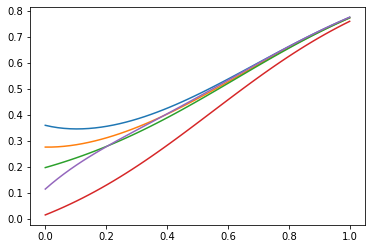

In [6]:
sim = m.forward(np.log(u0))

plt.plot(m.t, sim)
plt.show()

## Inference

Using this simulation as synthetic data, we now wish to infer the values of our model parameters and initial node values. 

We are going to do this using variational Bayes (VB). To do this, we set up a VB Model. 

In [7]:
# set guess for initial node concentration
p0 = np.ones([5])

# append initial guess for model parameters
u_guess = np.append(p0, [1.0,1.0])

# Instantiate probablistic model of type VBModel
ProbModel = VBModel(model=m, data=sim, init_means=u_guess)


We can then call the generic `infer` function to optimise our probablistic model.

In [8]:
pm = infer(ProbModel, n=20)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Finished!


Plotting the results, we can see that we obtain the correct values for our model parameters: 

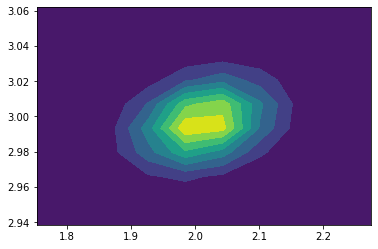

In [9]:
mean_a = np.exp(pm.m()[-2:])
cov_a = pm.Cov()[-2:,-2:]

samples = np.random.multivariate_normal(mean_a, cov_a, 100000)

(counts, x_bins, y_bins) = np.histogram2d(samples[:, 0], samples[:, 1])
plt.contourf(counts, extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]])
plt.show()

In [18]:
import plotly.graph_objects as go

def plot_2dmvn(means, cov, n):
    samples = np.random.multivariate_normal(means, cov, n)
    (counts, x_bins, y_bins) = np.histogram2d(samples[:, 0], samples[:, 1])
    
    fig = go.Figure(data =
        go.Contour(
            z=counts,
            x=x_bins, # horizontal axis
            y=y_bins# vertical axis
        ))
    return fig.show()